# Basic Plotting

These are examples of typical variables and plots that we look at in our sea ice diagnostics package. The most current version of the sea ice diagnostics are in the CESM Postprocessing. More information here: [CESM Postprocessing](https://github.com/NCAR/CESM_postprocessing).

In Exercise 1, you will learn about plotting sea ice area and other variables on a polar projection.

The first step is to import the libraries needed to plot the data. Here we will use `xarray` as a tool to read the netCDF file. We will use `numpy` for some basic math calculations. For plotting the data we will need `matplotlib`, `pop_tools`, `geocat` and `cartopy`.

## Exercise 1: Plot Sea Ice Concentration on a polar projection.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
import pop_tools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import nc_time_axis
import cftime
import os

The next few steps read in sea ice concentration or (`aice`) from one of the CESM2 large ensemble historical runs. Note this operation points to multiple files on the campaign file system, so we are using the `xarray` function `open_mfdataset` for a multifile dataset. We will also print the `aice` dataset to get an idea of the metadata and dimensions. Note that we could use the 10 year simulation from the tutorial. However, 10 years is very short and is not a very interesting timeseries. Instead we can use one of the CESM2 Large Ensemble historical simulations. [Rodgers et al. 2021](https://doi.org/10.5194/esd-12-1393-2021)

In [35]:
case1 = "b.e23_alpha16g.BLT1850.ne30_t232.057"
case2 = "b.e23_alpha16b.BLT1850.ne30_t232.054"
var = "aice"

climo_path = "/glade/cheyenne/scratch/dbailey/ADF/"

ds1 = xr.open_dataset(climo_path+case1+"/ts/"+case1+".cice.h."+var+".000101-004412.nc")
ds2 = xr.open_dataset(climo_path+case2+"/ts/"+case2+".cice.h."+var+".000101-004412.nc")

month_length = ds1.time.dt.days_in_month

# Calculate the weights by grouping by 'time.season'.
weights = (
    month_length.groupby("time.season") / month_length.groupby("time.season").sum()
)

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

# Calculate the weighted average
#ds1_weighted = (ds1 * weights).groupby("time.season").sum(dim="time")
#ds2_weighted = (ds2 * weights).groupby("time.season").sum(dim="time")

ds1_unweighted = ds1.groupby("time.season").mean("time")
ds2_unweighted = ds2.groupby("time.season").mean("time")

aice1_son = ds1_unweighted['aice'].sel(season="SON")
aice2_son = ds2_unweighted['aice'].sel(season="SON")

aice_diff = aice1_son-aice2_son
aice_std = aice_diff.std()
aice_max = aice_diff.max()
aice_min = aice_diff.min()

month_length

<xarray.DataArray 'days_in_month' (time: 528)>
array([31, 28, 31, ..., 31, 30, 31])
Coordinates:
  * time     (time) object 0001-01-16 12:00:00 ... 0044-12-16 12:00:00
Attributes:
    long_name:  time
    bounds:     time_bounds

The next step is to read in some grid information for the `gx1v7` dipole grid used in POP and CICE. We will read in three main variables: `tarea`, `TLAT`, and `TLON`. These are the areas of the gridcells along with the latitudes and longitudes of the gridcell centers. Also, we will print the latitude array `TLAT` to see the metadata.

In [24]:
TLAT = ds1['TLAT']
TLON = ds1['TLON']
tarea = ds1['tarea']

The next step is to set up the northern hemisphere polar stereographic projection for plotting the sea ice concentration `aice`. We are using a "rainbow" colormap here and cutting off the plot with a circular boundary. Note that we are only plotting the first timeslice of the `aice` array here.

Text(0.5, 1.0, 'Sea Ice Concentration Difference')

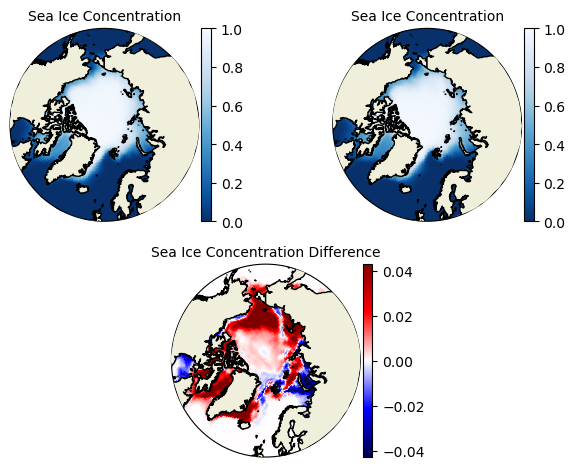

In [25]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# set up the figure with a North Polar Stereographic projection
fig = plt.figure(tight_layout=True)
gs = GridSpec(2, 4)

ax = fig.add_subplot(gs[0,:2], projection=ccrs.NorthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')

# sets the latitude / longitude boundaries of the plot
ax.set_extent([0.005, 360, 90, 55], crs=ccrs.PlateCarree())

this=ax.pcolormesh(TLON,
                   TLAT,
                   aice1_son,
                   cmap="Blues_r",vmax=1,vmin=0,
                   transform=ccrs.PlateCarree())
plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
plt.title('Sea Ice Concentration',fontsize=10)

ax = fig.add_subplot(gs[0,2:], projection=ccrs.NorthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')

# sets the latitude / longitude boundaries of the plot
ax.set_extent([0.005, 360, 90, 55], crs=ccrs.PlateCarree())

this=ax.pcolormesh(TLON,
                   TLAT,
                   aice2_son,
                   cmap="Blues_r",vmax=1,vmin=0,
                   transform=ccrs.PlateCarree())
plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
plt.title('Sea Ice Concentration',fontsize=10)

ax = fig.add_subplot(gs[1,1:3], projection=ccrs.NorthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')

# sets the latitude / longitude boundaries of the plot
ax.set_extent([0.005, 360, 90, 55], crs=ccrs.PlateCarree())

this=ax.pcolormesh(TLON,
                   TLAT,
                   aice_diff,
                   cmap="seismic",vmax=aice_std*2.0,vmin=-aice_std*2.0,
                   transform=ccrs.PlateCarree())
plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
plt.title('Sea Ice Concentration Difference',fontsize=10)



<div class="alert alert-success">   
<details>
<summary><font face="Times New Roman" color='blue'>Click here for the solution</font></summary><br>

![plot example](../../../images/diagnostics/cice/basics_plot_1.png)

*<p style="text-align: center;"> Figure: Plotting solution. </p>*
    
</details>
</div>

Questions

1. Why do we use February 1 to display the January monthly average? What does this mean for selecting e.g. September values?

2. Try other colormaps here. Some examples to try: `viridis`, `plasma`, `Blues`. Try reversing the colormaps. Hint: add the string `_r` to the colormap name.

3. Try a different timeslice from aice. Note the number of timeslices in the metadata you printed above. Note that the calendar goes from 1850-01 to 2015-12 as these are monthly mean time slices. Can you compute an annual mean over the 165 years and plot that? Can you compute the September mean over the 165 years and plot that?

Hint: Use aice.mean(dim='time')

4. Try sea ice thickness `hi` now. What happens to the colorbar? Try increasing the maximum value `vmax`. Note that you have to change the files that are read in.

Hint: Do a search and replace on `aice` with `hi`.

5. Now how about the Southern Hemisphere?


<div class="alert alert-success">   
<details>
<summary><font face="Times New Roman" color='blue'>Click here for the solution</font></summary><br>

1. Colormaps
```
cmap = plt.cm.get_cmap('viridis')
cmap = plt.cm.get_cmap('plasma')
cmap = plt.cm.get_cmap('Blues')
cmap = plt.cm.get_cmap('Blues_r')
```
<br>

2. Means
```
this=ax.pcolormesh(ds['TLONG'],
                   ds['TLAT'],
                   ds['aice'].sel({'time':'1850-10-01 00:00:00'}).squeeze(),
                   cmap=cmap,vmax=1,vmin=0,
                   transform=ccrs.PlateCarree())

this=ax.pcolormesh(ds['TLONG'],
                   ds['TLAT'],
                   ds['aice'].mean(dim='time'),
                   cmap=cmap,vmax=1,vmin=0,
                   transform=ccrs.PlateCarree())

this=ax.pcolormesh(ds['TLONG'],
                   ds['TLAT'],
                   ds['aice'].sel(time=ds.time.dt.month.isin([10])).mean(dim='time'),
                   cmap=cmap,vmax=1,vmin=0,
                   transform=ccrs.PlateCarree())
```
<br>

3. Ice Thickness
```
- change all occurences of `aice` to `hi`
- Try `vmax = 5`
```

4. Southern Hemisphere
```
ax = fig.add_subplot(1,3,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([0.005, 360, -90, -55], crs=ccrs.PlateCarree())
```

</details>
</div>

## Exercise 2: Plot a time series of total sea ice area.

The first step is to compute the ice area in each grid cell by multiplying the grid cell areas by the ice area fraction. Then we subset to just grid cells in the Northern hemisphere (using `where`). Finally, we sum over all of the grid cells. We can do these operations in a single line:

In [26]:
ds_area = (ds1.tarea*ds1.aice).where(ds1.TLAT>0).sum(dim=['nj','ni'])*1.0e-12

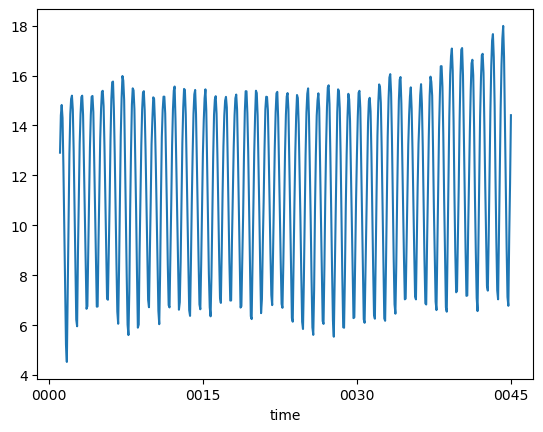

In [27]:
ds_area.plot()

<div class="alert alert-success">   
<details>
<summary><font face="Times New Roman" color='blue'>Click here for the solution</font></summary><br>

![plot example](../../../images/diagnostics/cice/basics_plot_2.png)

*<p style="text-align: center;"> Figure: Plotting solution. </p>*
    
</details>
</div>

This plot looks very noisy! Why do you think this is? Hint: you have plotted how many years of monthly mean data? Let's try just plotting September instead.

Refresher question: Why do we use month 10 (`ds_area.time.dt.month.isin([10])`) to reference September data?

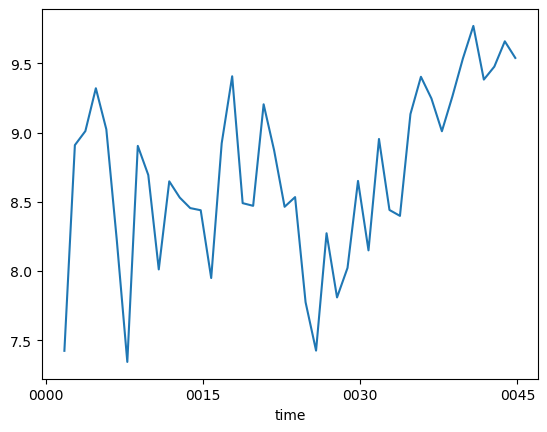

In [28]:
ds_area.sel(time=ds_area.time.dt.month.isin([10])).plot()

<div class="alert alert-success">   
<details>
<summary><font face="Times New Roman" color='blue'>Click here for the solution</font></summary><br>

![plot example](../../../images/diagnostics/cice/basics_plot_3.png)

*<p style="text-align: center;"> Figure: Plotting solution. </p>*
    
</details>
</div>

Now let's plot the observational data on top. The NSIDC Sea Ice Index will be the values we want. These are computed from satellite observations. More information can be found here [Sea Ice Index](https://nsidc.org/data/seaice_index).

In [29]:
##### Add the data values manually from the datafile.
##### Create an xarray object with the NSIDC values and the years from 1979 to 2022.

seaice_index = [4.58,4.87,4.44,4.43,4.7,4.11,4.23,4.72,5.64,5.36,4.86,4.55,4.51,5.43,4.58,5.13,4.43,5.62,\
                4.89,4.3,4.29,4.35,4.59,4.03,4.05,4.39,4.07,4.01,2.82,3.26,3.76,3.34,3.21,2.41,3.78,3.74,\
                3.42,2.91,3.35,3.35,3.17,2.83,3.47,3.47]

# Convert to m^2
seaice_index = np.array(seaice_index)
seaice_index *= 1e12

nsidc_time = [cftime.datetime(y, 10, 15) for y in range(1979,2023)]

nsidc_index = xr.DataArray(data=seaice_index,coords={"time":nsidc_time})

nsidc_index


<xarray.DataArray (time: 44)>
array([4.58e+12, 4.87e+12, 4.44e+12, 4.43e+12, 4.70e+12, 4.11e+12,
       4.23e+12, 4.72e+12, 5.64e+12, 5.36e+12, 4.86e+12, 4.55e+12,
       4.51e+12, 5.43e+12, 4.58e+12, 5.13e+12, 4.43e+12, 5.62e+12,
       4.89e+12, 4.30e+12, 4.29e+12, 4.35e+12, 4.59e+12, 4.03e+12,
       4.05e+12, 4.39e+12, 4.07e+12, 4.01e+12, 2.82e+12, 3.26e+12,
       3.76e+12, 3.34e+12, 3.21e+12, 2.41e+12, 3.78e+12, 3.74e+12,
       3.42e+12, 2.91e+12, 3.35e+12, 3.35e+12, 3.17e+12, 2.83e+12,
       3.47e+12, 3.47e+12])
Coordinates:
  * time     (time) object 1979-10-15 00:00:00 ... 2022-10-15 00:00:00

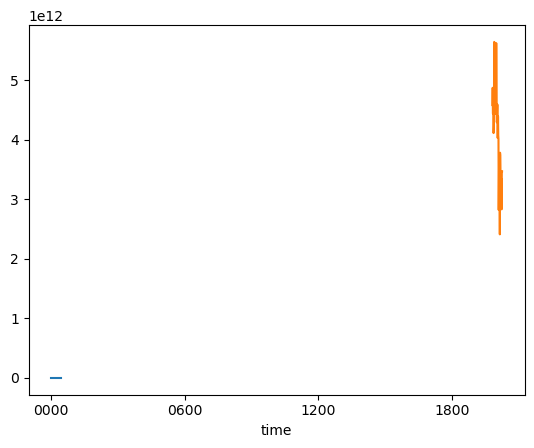

In [30]:
ds_area.sel(time=ds_area.time.dt.month.isin([10])).plot()
nsidc_index.plot()

<div class="alert alert-success">   
<details>
<summary><font face="Times New Roman" color='blue'>Click here for the solution</font></summary><br>

![plot example](../../../images/diagnostics/cice/basics_plot_4.png)

*<p style="text-align: center;"> Figure: Plotting solution. </p>*
    
</details>
</div>

Why do you think the observed (orange) does not correspond to the model? The answer is that the model is 1 of 100 ensemble realizations of the 20th century and will not necessarily correspond to the observed realization.

Things to try:

1. Try plotting the March total area time series. Hint: The first March is slice 2.

2. Try computing total ice volume and plotting it. Hint: Use the variable `hi` in place of `aice`. Note that volume is units of $m^3$. So, you might want to scale the volume by $1.0e-13$.

3. What does the Southern Hemisphere sea ice area and volume look like?

<div class="alert alert-success">   
<details>
<summary><font face="Times New Roman" color='blue'>Click here for the solution</font></summary><br>

1. March total area.
```
ds_area.sel(time=ds_area.time.dt.month.isin([4])).plot()
```
<br>

2. Ice Volume
```
ds_vol = (ds.TAREA*ds.hi).where(ds.TLAT>0).sum(dim=['nj','ni'])
```
<br>
    
3. Southern Hemisphere
```
ds_area = (ds.TAREA*ds.aice).where(ds.TLAT<0).sum(dim=['nj','ni'])
```
    
</details>
</div>